<a href="https://colab.research.google.com/github/AlinaStudyPM/UniversityML/blob/main/MyML_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install haversine

In [2]:
!pip install folium

In [168]:
import pandas as pd
import numpy as np
from haversine import haversine
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import folium

from IPython import display
from IPython.display import IFrame
from IPython.core.display import HTML

from sklearn.metrics import silhouette_score

In [130]:
def calculate_distance(row):
  return 1000 * haversine((latitude_metro, longitude_metro), (row['LATITUDE'], row['LONGITUDE']))

In [122]:
pd.set_option('display.max_rows', None)

In [124]:
pd.reset_option('display.max_rows')

Читаем данные из файла

In [125]:
data = pd.read_csv('ALL_SPB_STOPS.csv', encoding='CP1251', delimiter=';')
data

,ID_STOP,STOP_NAME,LATITUDE,LONGITUDE
0,100101,Пр.Ветеранов-1,59.841604,30.253984
1,100102,Пр.Ветеранов-2,59.842042,30.250084
2,100103,Ленинский пр.-1,59.851683,30.268385
3,100104,Ленинский пр.-2,59.849710,30.268348
4,100105,Автово,59.867292,30.261133
...,...,...,...,...
7149,4997,ЗАВОД ИМ. КАЛИНИНА [тест] <,59.950695,30.266132
7150,4998,МАЛЫЙ ПР. В.О. ПО 9 ЛИНИИ [тест] <,59.945698,30.271969
7151,5003,АДМИРАЛТЕЙСКИЙ ПР. [тест] <,59.936026,30.309259
7152,7069,ПР. ЛУНАЧАРСКОГО(тест),60.031439,30.392572


In [140]:
#Разделяем остановки на автобусные и метро
metro_stops = data[data['ID_STOP'].astype(str).str.startswith('100')]
auto_stops = data[~data['ID_STOP'].astype(str).str.startswith('100')]

Выбираем станцию метро

In [151]:
metro_name = "Маяковская"
radius = 1000
metro_stop_info = metro_stops[metro_stops['STOP_NAME'].str.contains(metro_name)]
latitude_metro = metro_stop_info['LATITUDE'].values[0]
longitude_metro = metro_stop_info['LONGITUDE'].values[0]
metro_stop_info

,ID_STOP,STOP_NAME,LATITUDE,LONGITUDE
47,100304,Маяковская,59.931592,30.355142


In [152]:
#Для каждой автобусной остановки считаем расстояние до выбранного метро
auto_stops['Distance'] = auto_stops.apply(calculate_distance, axis=1)
auto_stops

<ipython-input-152-80e5da2834fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_stops['Distance'] = auto_stops.apply(calculate_distance, axis=1)


,ID_STOP,STOP_NAME,LATITUDE,LONGITUDE,Distance
75,1282,"10 КМ [145, 165, 482, 482а, 482в, 484, 484б]",59.773372,30.125111,21784.100714
76,1285,12-13 ЛИНИИ (ПО СРЕДНЕМУ ПР. В.О.) [6],59.941121,30.271757,4764.235845
77,1287,18-19 ЛИНИИ [6],59.938798,30.264141,5132.274068
78,1290,"1-Я И КАДЕТСКАЯ ЛИНИЯ,УГ. СРЕДНЕГО ПР. [6]",59.944538,30.287008,4059.018984
79,1291,1-Я КРАСНОАРМЕЙСКАЯ УЛ. [71],59.915965,30.310436,3037.369714
...,...,...,...,...,...
7149,4997,ЗАВОД ИМ. КАЛИНИНА [тест] <,59.950695,30.266132,5393.442469
7150,4998,МАЛЫЙ ПР. В.О. ПО 9 ЛИНИИ [тест] <,59.945698,30.271969,4891.129809
7151,5003,АДМИРАЛТЕЙСКИЙ ПР. [тест] <,59.936026,30.309259,2603.194173
7152,7069,ПР. ЛУНАЧАРСКОГО(тест),60.031439,30.392572,11296.115270


In [155]:
#Оставляем только остановки на заданном расстоянии
nearby_auto_stops = auto_stops[auto_stops['Distance'] < radius]
nearby_auto_stops

,ID_STOP,STOP_NAME,LATITUDE,LONGITUDE,Distance
140,1377,"БКЗ ""ОКТЯБРЬСКИЙ""",59.936895,30.364611,791.183861
242,1476,"ДВОРЕЦ ТВОРЧЕСТВА ЮНЫХ [7, 3, 27, 22, 24]",59.933590,30.339277,911.337175
290,14902,"Пять углов (3, 8, 15)",59.926304,30.343023,895.383815
294,14907,"Владимирская площадь (3, 8, 15)",59.929517,30.347792,470.025637
296,14909,"Невский проспект (3, 8, 15)",59.933391,30.348150,437.907500
...,...,...,...,...,...
6882,4217,ЛИТЕЙНЫЙ ПР. (тест),59.933371,30.348068,440.952260
6883,4218,МАРИИНСКАЯ БОЛЬНИЦА (тест),59.934743,30.348238,520.295171
6886,4223,"УЛ. НЕКРАСОВА, 1",59.938938,30.349131,882.813789
6887,4243,УЛ. ВОССТАНИЯ (тест),59.938729,30.360935,856.725814


Кластеризация

In [156]:
coords = nearby_auto_stops[['LATITUDE', 'LONGITUDE']].values

In [239]:
#Метод KMeans

number_of_clusters_kmeans = 16

model_kmeans = KMeans(n_clusters=number_of_clusters_kmeans, random_state=42)
clusters_kmeans = model_kmeans.fit_predict(coords)

nearby_auto_stops['KMeans_Cluster'] = clusters_kmeans
nearby_auto_stops

<ipython-input-239-6b7693d9747f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearby_auto_stops['KMeans_Cluster'] = clusters_kmeans


,ID_STOP,STOP_NAME,LATITUDE,LONGITUDE,Distance,KMeans_Cluster,DBSCAN_Cluster
140,1377,"БКЗ ""ОКТЯБРЬСКИЙ""",59.936895,30.364611,791.183861,9,0
242,1476,"ДВОРЕЦ ТВОРЧЕСТВА ЮНЫХ [7, 3, 27, 22, 24]",59.933590,30.339277,911.337175,4,1
290,14902,"Пять углов (3, 8, 15)",59.926304,30.343023,895.383815,11,2
294,14907,"Владимирская площадь (3, 8, 15)",59.929517,30.347792,470.025637,5,3
296,14909,"Невский проспект (3, 8, 15)",59.933391,30.348150,437.907500,1,4
...,...,...,...,...,...,...,...
6882,4217,ЛИТЕЙНЫЙ ПР. (тест),59.933371,30.348068,440.952260,1,4
6883,4218,МАРИИНСКАЯ БОЛЬНИЦА (тест),59.934743,30.348238,520.295171,1,4
6886,4223,"УЛ. НЕКРАСОВА, 1",59.938938,30.349131,882.813789,8,5
6887,4243,УЛ. ВОССТАНИЯ (тест),59.938729,30.360935,856.725814,2,10


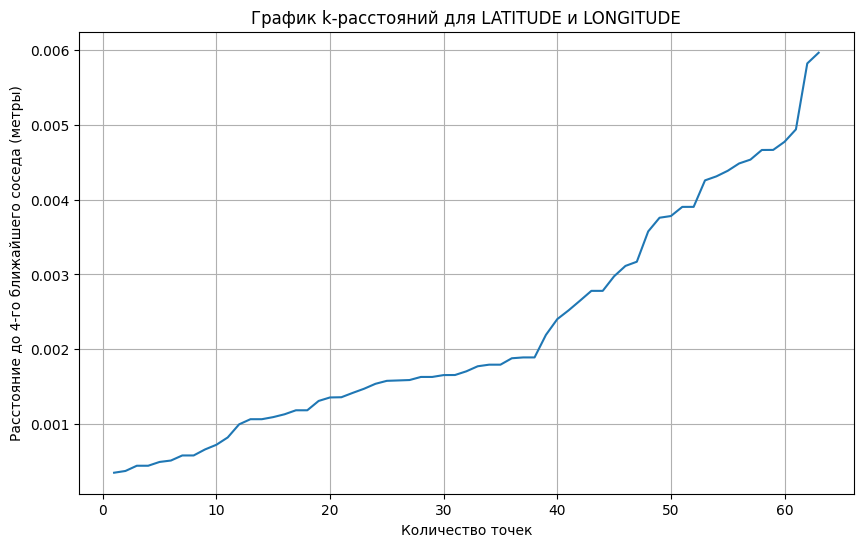

In [160]:
#Строим график k-расстояний, чтобы выбрать параметры для DBSCAN

k = 4

neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(coords)
distances, indices = neighbors.kneighbors(coords)

distances = np.sort(distances[:, k-1])

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(distances) + 1), distances)
plt.title('График k-расстояний для LATITUDE и LONGITUDE')
plt.xlabel('Количество точек')
plt.ylabel(f'Расстояние до {k}-го ближайшего соседа (метры)')
plt.grid(True)
plt.show()

In [240]:
#Метод DBSCAN

model_dbscan = DBSCAN(eps=0.002, min_samples=1)
clusters_dbscan = model_dbscan.fit_predict(coords)

nearby_auto_stops['DBSCAN_Cluster'] = clusters_dbscan

nearby_auto_stops

<ipython-input-240-0f6395cd34d3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearby_auto_stops['DBSCAN_Cluster'] = clusters_dbscan


,ID_STOP,STOP_NAME,LATITUDE,LONGITUDE,Distance,KMeans_Cluster,DBSCAN_Cluster
140,1377,"БКЗ ""ОКТЯБРЬСКИЙ""",59.936895,30.364611,791.183861,9,0
242,1476,"ДВОРЕЦ ТВОРЧЕСТВА ЮНЫХ [7, 3, 27, 22, 24]",59.933590,30.339277,911.337175,4,1
290,14902,"Пять углов (3, 8, 15)",59.926304,30.343023,895.383815,11,2
294,14907,"Владимирская площадь (3, 8, 15)",59.929517,30.347792,470.025637,5,3
296,14909,"Невский проспект (3, 8, 15)",59.933391,30.348150,437.907500,1,4
...,...,...,...,...,...,...,...
6882,4217,ЛИТЕЙНЫЙ ПР. (тест),59.933371,30.348068,440.952260,1,4
6883,4218,МАРИИНСКАЯ БОЛЬНИЦА (тест),59.934743,30.348238,520.295171,1,4
6886,4223,"УЛ. НЕКРАСОВА, 1",59.938938,30.349131,882.813789,8,5
6887,4243,УЛ. ВОССТАНИЯ (тест),59.938729,30.360935,856.725814,2,10


Отображаем результаты

In [247]:
colors = [
    'red',
    'blue',
    'gray',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black',
    'darkred',
    'lightred'
]

In [241]:
map_stops_kmeans = folium.Map(
    location=[latitude_metro, longitude_metro],
    zoom_start=15,
)

for i in range(number_of_clusters_kmeans):
  cluster_data = nearby_auto_stops[nearby_auto_stops['KMeans_Cluster'] == i]
  for _, row in cluster_data.iterrows():
    folium.Marker(
        location=(row['LATITUDE'], row['LONGITUDE']),
        popup = 'Кластер ' + str(row['KMeans_Cluster']) + ': ' +row['STOP_NAME'],
        icon=folium.Icon(color=colors[i])
        ).add_to(map_stops_kmeans)
map_stops_kmeans.save('KMeans.html')

#IFrame('KMeans.html', width=700, height=500)

#with open('KMeans.html', 'r') as f:
#    html_content = f.read()
#print(html_content)
#HTML(html_content)
#IFrame(html_content, width=700, height=500)

In [248]:
map_stops_dbscan = folium.Map(
    location=[latitude_metro, longitude_metro],
    zoom_start=15,
)

for cluster_label in nearby_auto_stops['DBSCAN_Cluster'].unique():
        if cluster_label != -1:  # Пропускаем шумовые точки, если есть
            cluster_data = nearby_auto_stops[nearby_auto_stops['DBSCAN_Cluster'] == cluster_label]
            for _, row in cluster_data.iterrows():
              folium.Marker(
                  location=(row['LATITUDE'], row['LONGITUDE']),
                  popup = 'Кластер ' + str(cluster_label) + ': ' +row['STOP_NAME'],
                  icon=folium.Icon(color=colors[cluster_label])
              ).add_to(map_stops_dbscan)
map_stops_dbscan.save('DBSCAN.html')

In [237]:
nearby_auto_stops['DBSCAN_Cluster'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

Оценка качества кластеризации

In [238]:
kmeans_silhouette = silhouette_score(coords, clusters_kmeans)
dbscan_silhouette = silhouette_score(coords, model_dbscan.labels_) if len(set(clusters_dbscan)) > 1 else -1  # В случае единственного кластера

print(f'Метрика Силуэт для KMeans: {kmeans_silhouette:.2f}')
print(f'Метрика Силуэт для DBSCAN: {dbscan_silhouette:.2f}')

Метрика Силуэт для KMeans: 0.64
Метрика Силуэт для DBSCAN: 0.62
